In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense,Lambda,Reshape,Conv1DTranspose, Conv1D,Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn

# Load and Define Data

In [2]:
df = pd.read_csv('../Data/PUMA-1204-2012to2016-5%_Treated.csv')
df

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA,ST
0,3,4,46,1,1,2,3,2,1,1204,24
1,3,4,44,1,1,1,3,2,1,1204,24
2,3,4,13,1,0,2,3,2,1,1204,24
3,3,4,8,1,0,2,3,2,1,1204,24
4,4,3,70,2,6,1,3,4,1,1204,24
...,...,...,...,...,...,...,...,...,...,...,...
4499,4,2,73,1,6,2,1,4,1,1204,24
4500,5,4,38,1,1,1,3,2,1,1204,24
4501,5,4,36,9,1,2,3,2,1,1204,24
4502,5,4,12,1,0,1,3,2,1,1204,24


In [3]:
df=df.fillna(df.mean())
df

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA,ST
0,3,4,46,1,1,2,3,2,1,1204,24
1,3,4,44,1,1,1,3,2,1,1204,24
2,3,4,13,1,0,2,3,2,1,1204,24
3,3,4,8,1,0,2,3,2,1,1204,24
4,4,3,70,2,6,1,3,4,1,1204,24
...,...,...,...,...,...,...,...,...,...,...,...
4499,4,2,73,1,6,2,1,4,1,1204,24
4500,5,4,38,1,1,1,3,2,1,1204,24
4501,5,4,36,9,1,2,3,2,1,1204,24
4502,5,4,12,1,0,1,3,2,1,1204,24


In [4]:
df.shape

(4504, 11)

# Data Preprocessing

In [5]:
X_train,X_test=train_test_split(df,test_size=200)

In [6]:
minmax=MinMaxScaler()
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [7]:
def fit_batchsize(X,batch_size):
    n_size = (len(X)//batch_size)*batch_size
    X = X[0:n_size]

    return X
batch_size = 10
X_train = fit_batchsize(X_train, batch_size)
X_test = fit_batchsize(X_test, batch_size)

In [8]:
X_train=X_train.astype(np.float32)

# Define GAN Model

In [9]:
def discriminator():
    
    d = Sequential()
    d.add(Reshape(target_shape=(11,1),input_shape=(11,)))
    d.add(Conv1D(12,3, activation="relu", strides=1, padding="same"))
    d.add(Conv1D(24,3, activation="relu", strides=1, padding="same"))
    d.add(Flatten())
    d.add(Dense(1))
    return d

In [10]:
def generator(latent_dim=2):

    g = Sequential()
    g.add(Dense(11*24,activation="relu", input_shape=(latent_dim,)))
    g.add(Reshape(target_shape=(11,24)))
    g.add(Conv1DTranspose(24,3,activation="relu", strides=1, padding="same"))
    g.add(Conv1DTranspose(12,3,activation="relu", strides=1, padding="same"))
    g.add(Conv1DTranspose(1,3,activation="relu", strides=1, padding="same"))
    g.add(Reshape(target_shape=(11,)))

    return g

In [11]:
discriminator = discriminator()
generator = generator()
print(discriminator.summary(), generator.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 11, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 12)            48        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 24)            888       
_________________________________________________________________
flatten (Flatten)            (None, 264)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 265       
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Out

In [12]:
class GAN(keras.Model):
    
  # initialize models with latent dimensions
  def __init__(self, disc, gen, latent_dim=2):
    super(GAN, self).__init__()
    self.discriminator = disc
    self.generator = gen
    self.latent_dim = latent_dim
  
  # compile with optimizers and loss function
  def compile(self, optD, optG, loss_fn):
    super(GAN, self).compile()
    self.optD = optD
    self.optG = optG
    self.loss_fn = loss_fn
    
  # custom training function
  def train_step(self, real_data):
    if isinstance(real_data, tuple):
      real_data = real_data[0]
    
    # get current batch size
    bs = tf.shape(real_data)[0]
    z = tf.random.normal(shape=(bs, self.latent_dim))
    fake_data = self.generator(z)
    
    # combine real and fake images in a single vector along with their labels
    combined_data = tf.concat([real_data, fake_data], axis=0)
    labels = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)
    
    # train your discriminator
    with tf.GradientTape() as tape:
      preds = self.discriminator(combined_data)
      d_loss = self.loss_fn(labels, preds)
      grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
      self.optD.apply_gradients(zip(grads, self.discriminator.trainable_weights))
    
    # misleading labels for generator
    misleading_labels = tf.ones((bs, 1))
    z = tf.random.normal(shape=(bs, self.latent_dim))
    
    # train your generator
    with tf.GradientTape() as tape:
      fake_preds = self.discriminator(self.generator(z))
      g_loss = self.loss_fn(misleading_labels, fake_preds)
      grads = tape.gradient(g_loss, self.generator.trainable_weights)
      self.optG.apply_gradients(zip(grads, self.generator.trainable_weights))
    return {"d_loss": d_loss, "g_loss": g_loss}
# create GAN model using already built D and G
gan = GAN(discriminator, generator)
# compile your model with loss and optimizers
gan.compile(
    keras.optimizers.Adam(),
    keras.optimizers.Adam(),
    keras.losses.BinaryCrossentropy(from_logits=True)
    )

In [13]:
hist=gan.fit(X_train,epochs=100)

Epoch 1/100
135/135 [==============================] - 1s 3ms/step - d_loss: 0.6817 - g_loss: 0.7235
Epoch 2/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6825 - g_loss: 0.7398
Epoch 3/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6604 - g_loss: 0.7757
Epoch 4/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6793 - g_loss: 0.7914
Epoch 5/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6518 - g_loss: 0.7904
Epoch 6/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6908 - g_loss: 0.7361
Epoch 7/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6926 - g_loss: 0.7077
Epoch 8/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6733 - g_loss: 0.7397
Epoch 9/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6886 - g_loss: 0.6965
Epoch 10/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.6873 - g_lo

135/135 [==============================] - 0s 3ms/step - d_loss: 0.0693 - g_loss: 3.1310
Epoch 82/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.0694 - g_loss: 3.2202
Epoch 83/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.0676 - g_loss: 3.2938
Epoch 84/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.0608 - g_loss: 3.4688
Epoch 85/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.0607 - g_loss: 3.4302
Epoch 86/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.0593 - g_loss: 3.4011
Epoch 87/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.0536 - g_loss: 3.5084
Epoch 88/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.0636 - g_loss: 3.4802
Epoch 89/100
135/135 [==============================] - 0s 3ms/step - d_loss: 1.1433 - g_loss: 1.3992
Epoch 90/100
135/135 [==============================] - 0s 3ms/step - d_loss: 0.3724 - g_loss: 

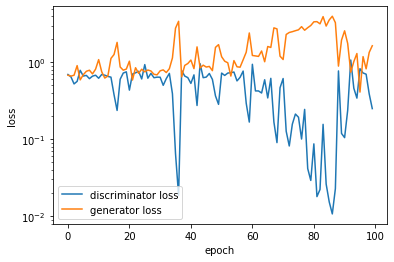

In [14]:
plt.figure()
plt.semilogy(hist.history['d_loss'],label='discriminator loss')
plt.semilogy(hist.history['g_loss'],label='generator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [15]:
latent_dim=2
z=tf.random.normal(shape=(20200,latent_dim))
generated_data=generator(z)
generated_data

<tf.Tensor: shape=(20200, 11), dtype=float32, numpy=
array([[0.6812159 , 0.51036984, 0.41600037, ..., 0.        , 0.        ,
        0.        ],
       [0.78582484, 0.23052949, 0.3763227 , ..., 0.        , 0.        ,
        0.        ],
       [0.7867161 , 0.15180892, 0.38929036, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.7847729 , 0.24241179, 0.37414825, ..., 0.        , 0.        ,
        0.        ],
       [0.7280132 , 0.32833034, 0.47596857, ..., 0.        , 0.        ,
        0.        ],
       [0.74033785, 0.32258263, 0.48829192, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [16]:
generated_data=minmax.inverse_transform(generated_data)
generated_data

array([[4.72486353e+00, 5.06221902e+00, 3.91040344e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       [5.14329934e+00, 3.38317692e+00, 3.53743325e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       [5.14686441e+00, 2.91085351e+00, 3.65932941e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       ...,
       [5.13909149e+00, 3.45447075e+00, 3.51699355e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       [4.91205287e+00, 3.96998203e+00, 4.47410455e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01],
       [4.96135139e+00, 3.93549579e+00, 4.58994404e+01, ...,
        1.00000000e+00, 1.20400000e+03, 2.40000000e+01]])

In [17]:
generated_data=np.round(generated_data)
generated_data

array([[5.000e+00, 5.000e+00, 3.900e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       [5.000e+00, 3.000e+00, 3.500e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       [5.000e+00, 3.000e+00, 3.700e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       ...,
       [5.000e+00, 3.000e+00, 3.500e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       [5.000e+00, 4.000e+00, 4.500e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01],
       [5.000e+00, 4.000e+00, 4.600e+01, ..., 1.000e+00, 1.204e+03,
        2.400e+01]])

In [18]:
generated_data=pd.DataFrame(generated_data)

In [19]:
generated_data.to_csv('GAN reconstruction PUMA==1204.csv')